# Training simple CNN to classify CIFAR10 dataset

The implementation of the CNN net is taken from the: https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py

According to that file:
```
It gets to 75% validation accuracy in 25 epochs, and 79% after 50 epochs.
(it's still underfitting at that point, though).
```
When trained with single learning rate and RMSprop optimizer:
```
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
```
Here we do manual scheduling of learning rate and no data augmentation is used. The `std` normalized gradients optimizer reach 80% after only 20 epochs. After 45 epochs the final validation accuracy is 82%.

# Setup

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import tensorflow as tf
tf.__version__

In [3]:
import sys
sys.path.append("../src/")
import keras_cifar_cnn as cnn
import tf_optimizer as tf_opt
import callbacks as clb
import utils as ut
from plotting import set_display_settings
set_display_settings()

from keras.optimizers import TFOptimizer
from keras.callbacks import History

Using TensorFlow backend.


## Dataset and model definition

In [4]:
x_train, y_train, validation_set, datagen = cnn.get_dataset()

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
model = cnn.get_cnn()
batch_size = 32

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

# Train model with `AdaptiveNormalizedSGD`

Some notes: 

* `AdaptiveNormalizedSGD` is set to normalize gradients by their standard deviation.
* No momentum is used, since it did not improve results for this case.
* Adaptive learning rate is disabled. 

In [41]:
model = cnn.get_cnn()
metrics_history = [clb.AggregateMetricsOnBatchEnd(), clb.AggregateMetricsOnEpochEnd()]

for lr in [0.001, 0.0005, 0.0001, 0.00001]:        
    # max norm was working fine but a little worse than Adam, I have tried std norm.
    #optimizer = TFOptimizer(tf_opt.LmaxNormalizedSGD(lr=lr))
    optimizer = TFOptimizer(tf_opt.AdaptiveNormalizedSGD(
        lr=lr, lr_update=0.0, momentum=0.0, momentum_update=0.00, norm_type='std'
    ))
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(
        x=x_train, y=y_train, batch_size=batch_size,
        epochs=15,
        validation_data=validation_set, 
        callbacks=metrics_history)

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 37s 731us/step - loss: 1.7235 - acc: 0.3704 - val_loss: 1.3973 - val_acc: 0.4881
Epoch 2/15
50000/50000 [==============================] - 33s 657us/step - loss: 1.2950 - acc: 0.5369 - val_loss: 1.0934 - val_acc: 0.6145
Epoch 3/15
50000/50000 [==============================] - 33s 653us/step - loss: 1.0945 - acc: 0.6130 - val_loss: 1.0749 - val_acc: 0.6297
Epoch 4/15
50000/50000 [==============================] - 33s 658us/step - loss: 0.9746 - acc: 0.6608 - val_loss: 0.8802 - val_acc: 0.6888
Epoch 5/15
50000/50000 [==============================] - 33s 655us/step - loss: 0.8980 - acc: 0.6873 - val_loss: 0.8743 - val_acc: 0.6941
Epoch 6/15
50000/50000 [==============================] - 32s 639us/step - loss: 0.8352 - acc: 0.7127 - val_loss: 0.8490 - val_acc: 0.7149
Epoch 7/15
50000/50000 [==============================] - 33s 651us/step - loss: 0.7822 - acc: 0.7290 - val_loss: 0.

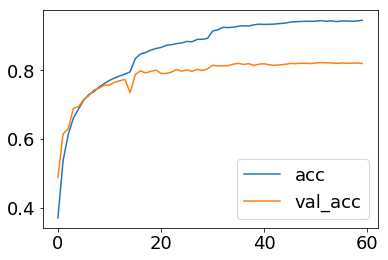

In [42]:
hist = metrics_history[1].monitor_values['accuracies']
for k, v in hist.items():
    if len(v) != 0: plt.plot(v, label=k)
plt.legend()

# Training with Adam optimizer

In [ ]:
# Adam was not able to train with lr=0.005

In [22]:
from keras.optimizers import Adam, SGD

model = cnn.get_cnn()
adam_metrics_history = [clb.AggregateMetricsOnBatchEnd(), clb.AggregateMetricsOnEpochEnd()]

for lr in [0.001, 0.0005, 0.0001]:    
    optimizer = Adam(lr=lr)
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(
        x=x_train, y=y_train, batch_size=batch_size,
        epochs=15,
        validation_data=validation_set, 
        callbacks=adam_metrics_history)

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 26s 529us/step - loss: 1.5387 - acc: 0.4370 - val_loss: 1.1909 - val_acc: 0.5680
Epoch 2/15
50000/50000 [==============================] - 28s 566us/step - loss: 1.1469 - acc: 0.5948 - val_loss: 0.9731 - val_acc: 0.6598
Epoch 3/15
50000/50000 [==============================] - 28s 568us/step - loss: 0.9829 - acc: 0.6557 - val_loss: 0.8683 - val_acc: 0.6989
Epoch 4/15
50000/50000 [==============================] - 28s 567us/step - loss: 0.8969 - acc: 0.6864 - val_loss: 0.7794 - val_acc: 0.7269
Epoch 5/15
50000/50000 [==============================] - 28s 564us/step - loss: 0.8266 - acc: 0.7111 - val_loss: 0.7581 - val_acc: 0.7376
Epoch 6/15
50000/50000 [==============================] - 28s 564us/step - loss: 0.7817 - acc: 0.7271 - val_loss: 0.7773 - val_acc: 0.7324
Epoch 7/15
50000/50000 [==============================] - 28s 566us/step - loss: 0.7503 - acc: 0.7352 - val_loss: 0.

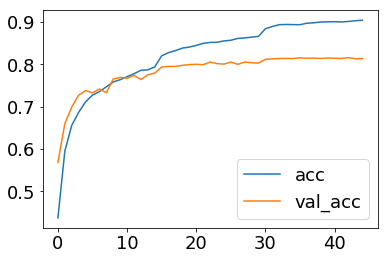

In [23]:
hist = adam_metrics_history[1].monitor_values['accuracies']
for k, v in hist.items():
    if len(v) != 0: plt.plot(v, label=k)
plt.legend()

# Training with SGD and momentum=0.9

In [47]:
model = cnn.get_cnn()
momentum_metrics_history = [clb.AggregateMetricsOnBatchEnd(), clb.AggregateMetricsOnEpochEnd()]

for lr in [0.01, 0.005, 0.001]:    
    optimizer = SGD(lr=lr, momentum=0.9)
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(
        x=x_train, y=y_train, batch_size=batch_size,
        epochs=15,
        validation_data=validation_set, 
        callbacks=momentum_metrics_history)

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 32s 648us/step - loss: 2.1440 - acc: 0.1960 - val_loss: 1.9455 - val_acc: 0.2930
Epoch 2/15
50000/50000 [==============================] - 28s 555us/step - loss: 1.8683 - acc: 0.3162 - val_loss: 1.6503 - val_acc: 0.3994
Epoch 3/15
50000/50000 [==============================] - 28s 550us/step - loss: 1.6265 - acc: 0.4042 - val_loss: 1.5294 - val_acc: 0.4546
Epoch 4/15
50000/50000 [==============================] - 28s 562us/step - loss: 1.4967 - acc: 0.4537 - val_loss: 1.3564 - val_acc: 0.5115
Epoch 5/15
50000/50000 [==============================] - 28s 553us/step - loss: 1.4055 - acc: 0.4912 - val_loss: 1.2680 - val_acc: 0.5439
Epoch 6/15
50000/50000 [==============================] - 28s 553us/step - loss: 1.3326 - acc: 0.5189 - val_loss: 1.2064 - val_acc: 0.5640
Epoch 7/15
50000/50000 [==============================] - 28s 551us/step - loss: 1.2725 - acc: 0.5446 - val_loss: 1.

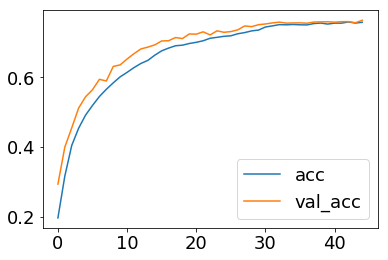

In [49]:
hist = momentum_metrics_history[1].monitor_values['accuracies']
for k, v in hist.items():
    if len(v) != 0: plt.plot(v, label=k)
plt.legend()

# Plots for comparison

In [60]:
hists = {
  'NSGD': metrics_history,
  'Adam': adam_metrics_history,
  'Momentum': momentum_metrics_history
} 

num_epochs = 45

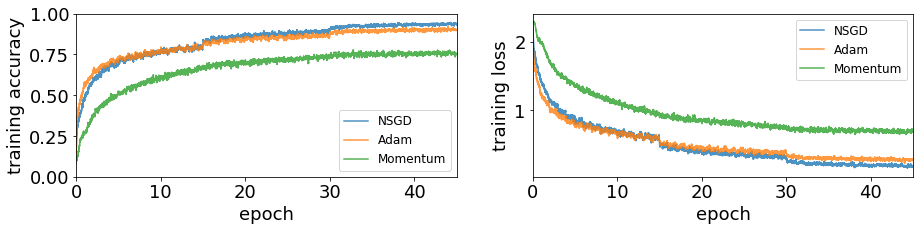

In [63]:
plt.figure(figsize=(15, 3))
plt.subplot(121)
for opt, hist in hists.items():
    h = hist[0].monitor_values['accuracies']['acc']
    h = ut.moving_average(h, periods=100)
    step_to_epoch = np.linspace(0, len(h)/(50000/batch_size), len(h))
    plt.plot(step_to_epoch, h, label=opt, alpha=0.8)
plt.ylim([0, 1])
plt.xlim([0, num_epochs])
plt.legend(fontsize=12, loc='lower right')
plt.xlabel('epoch')
plt.ylabel('training accuracy')

plt.subplot(122)
for opt, hist in hists.items():
    h = hist[0].monitor_values['losses']['loss']
    h = ut.moving_average(h, periods=100)
    step_to_epoch = np.linspace(0, len(h)/(50000/batch_size), len(h))
    plt.plot(step_to_epoch, h, label=opt, alpha=0.8)
plt.legend(fontsize=12, loc='upper right')
plt.xlim([0, num_epochs])
plt.xlabel('epoch')
plt.ylabel('training loss')
# plt.savefig('../img/cifar10_cnn_training.pdf')
# plt.savefig('../img/cifar10_cnn_training.png')

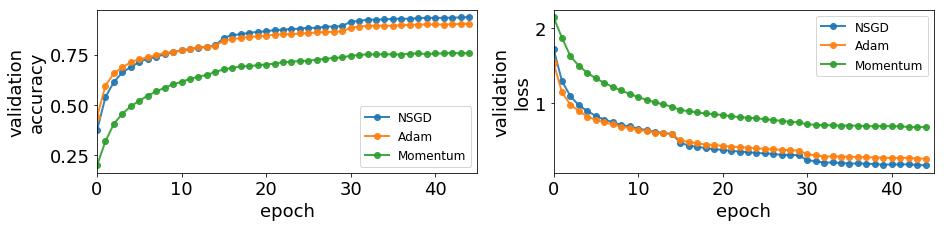

In [64]:
plt.figure(figsize=(15, 3))
plt.subplot(121)

for opt, hist in hists.items():
    h = hist[1].monitor_values['accuracies']['val_acc']
    plt.plot(h[:num_epochs], 'o-',label=opt,  alpha=0.9, linewidth=2)
plt.legend(fontsize=12, loc='lower right')
plt.xlabel('epoch')
plt.ylabel('validation\naccuracy')
plt.xlim([0, num_epochs])

plt.subplot(122)
for opt, hist in hists.items():
    h = hist[1].monitor_values['losses']['val_loss']
    plt.plot(h[:num_epochs], 'o-', label=opt,  alpha=0.9, linewidth=2)
plt.legend(fontsize=12, loc='upper right')
plt.xlabel('epoch')
plt.ylabel('validation\nloss')
plt.xlim([0, num_epochs])
# plt.savefig('../img/cifar10_cnn_validation.pdf')
# plt.savefig('../img/cifar10_cnn_validation.png')